In [1]:
import numpy as np 
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from thermal.plotting import enthalpy_pcolormesh
from thermal.derived_fields import (calc_length,
                                    calc_mean_enthalpy)

plt.rcParams.update({'font.size': 12, 
                     'text.usetex': True})

In [2]:
nz_15 = '/Volumes/thermal_ssd/new_1aTST/crmpt12_dx_50_NT_30000_dt_0.1_1aTST_f_dd_0.006.zarr/'
nz_30 = '/Volumes/thermal_ssd/new_1aTST/crmpt12_dx_50_NT_30000_dt_0.1_1aTST_NZ_30.zarr/'

7.713510985630002
3.8508327606560333


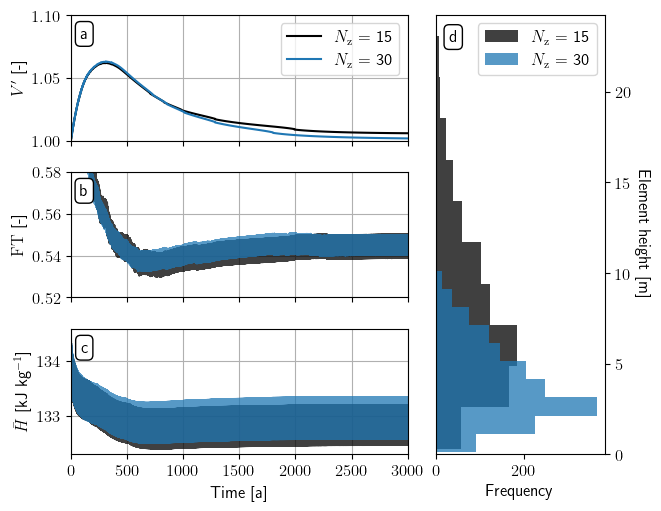

In [3]:
fig = plt.figure(figsize=(6.5,5),constrained_layout=True)

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[2, :2])
ax4 = fig.add_subplot(gs[:, 2])

labels = [r'$N_{\rm z}$ = 15', r'$N_{\rm z}$ = 30']
colors = ['k', 'tab:blue']

for i, fn in enumerate([nz_15, nz_30]):  
    src = xr.open_zarr(fn)
    
    v_prime = src.relative_volume / src.relative_volume[0]
    H_bar   = calc_mean_enthalpy(src) / 1e3
    
    ax1.plot(src.t, v_prime, label=labels[i], color=colors[i])
    
    ax2.plot(src.t, src.percent_temperate / 1e2, alpha=0.75, color=colors[i])
    # ax2.plot(src.t, (src.percent_temperate / 1e2).rolling(t=10).mean(), color=colors[i])
    
    ax3.plot(src.t, H_bar, alpha=0.75, color=colors[i])
    # ax3.plot(src.t, H_bar.rolling(t=10).mean(), color=colors[i])

    L = calc_length(src.isel(t=-1).compute())
    # get the vertical gridcell spacing, but only within the ice domain
    dz = src.isel(t=-1).where(lambda x: x.X[-1] > L*1e3).Z.diff('coord_2').values.flatten()
    # number of valid vertical gridcells
    N = np.count_nonzero(~np.isnan(dz))
    
    print(np.nanmean(dz))
    
    ax4.hist(dz, color=colors[i], 
             label=labels[i], histtype='stepfilled',
             orientation='horizontal', alpha=0.75)
     
labels = ['a', 'b', 'c']      
for i, ax in enumerate([ax1, ax2, ax3]): 
    ax.text(0.04, 0.85, labels[i], 
    ha='center', va='center', transform=ax.transAxes, 
    bbox=dict(boxstyle="round", fc='w') )
    
ax4.text(0.1, 0.95, 'd', 
         ha='center', va='center', transform=ax4.transAxes, 
         bbox=dict(boxstyle="round", fc='w') )

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.legend()
ax4.legend()

ax3.set_xlabel('Time [a]')
ax1.set_ylabel("$V'$ [-]")
ax2.set_ylabel(r'$\mathrm{FT}$ [-]');
ax3.set_ylabel(r'$\bar{H}$ [kJ kg$^{-1}$]');
ax4.set_ylabel('Element height [m]', rotation=270, labelpad=15)
ax4.set_xlabel('Frequency')

ax1.grid()
ax2.grid()
ax3.grid()

ax1.set_ylim(1.00, 1.1)
ax2.set_ylim(0.52, 0.58)
ax1.set_xlim(0, 3e3);
ax2.set_xlim(0, 3e3);
ax3.set_xlim(0, 3e3);
ax4.set_ylim(0, None);


fig.savefig('figs/crmpt12/mesh_refinement.pdf')
fig.savefig('figs/crmpt12/mesh_refinement.png', dpi=600)

# Comparison Metrics

In [147]:
src_list = [] 

for nz, fp in zip([15, 30], [nz_15, nz_30]): 
    
    print(fp)
    src = xr.open_zarr(fp).expand_dims('nz').assign_coords({'nz': ('nz', [nz])})
    
    src['relative_volume'] = src.relative_volume / src.relative_volume.isel(t=0)
    
    # src_list.append(src)
    src_list.append(src.isel(t=slice(-10,None)))


/Volumes/thermal_ssd/new_1aTST/crmpt12_dx_50_NT_30000_dt_0.1_1aTST_f_dd_0.006.zarr/
/Volumes/thermal_ssd/new_1aTST/crmpt12_dx_50_NT_30000_dt_0.1_1aTST_NZ_30.zarr/


In [109]:
for src in [nz15_src, nz30_src]: 

    FT = src.percent_temperate / 1e2
    H_bar = calc_mean_enthalpy(src).compute() / 1e3 
    

    print(float(FT.max() - FT.min())* 100)

    print(float(H_bar.max() - H_bar.min()))
    
    

1.108405213835939
0.5808280129243997
0.9281262288445169
0.5957878099181642


In [181]:
V_diff = src_list[1].relative_volume.squeeze()[-1] - src_list[0].relative_volume.squeeze()[-1]
V_mean = (src_list[1].relative_volume.squeeze()[-1] + src_list[0].relative_volume.squeeze()[-1]) / 2

print(float(V_diff/V_mean)* 100 )

-0.41096339190744047


In [188]:
float((calc_mean_enthalpy(src_list[1]).squeeze() - calc_mean_enthalpy(src_list[0]).squeeze()).isel(t=-1).squeeze()) / 1e2

1.9950558738628752

In [112]:
src_list[1].coarsen(coord_2=2, boundary='trim').mean()

<xarray.Dataset>
Dimensions:                (nz: 1, coord_2: 8, coord_1: 222, t: 10)
Coordinates:
  * t                      (t) float64 2.999e+03 2.999e+03 ... 3e+03 3e+03
  * nz                     (nz) int64 15
Dimensions without coordinates: coord_2, coord_1
Data variables: (12/23)
    X                      (nz, coord_2, coord_1) float64 dask.array<chunksize=(1, 8, 222), meta=np.ndarray>
    Z                      (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    densi                  (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    depth                  (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    enthalpy_h             (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    height                 (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    ...                     ...
    vel_x                  (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    vel_z                  (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    w                      (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    water content          (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    zbed                   (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>
    zs                     (nz, t, coord_2, coord_1) float64 dask.array<chunksize=(1, 10, 8, 222), meta=np.ndarray>

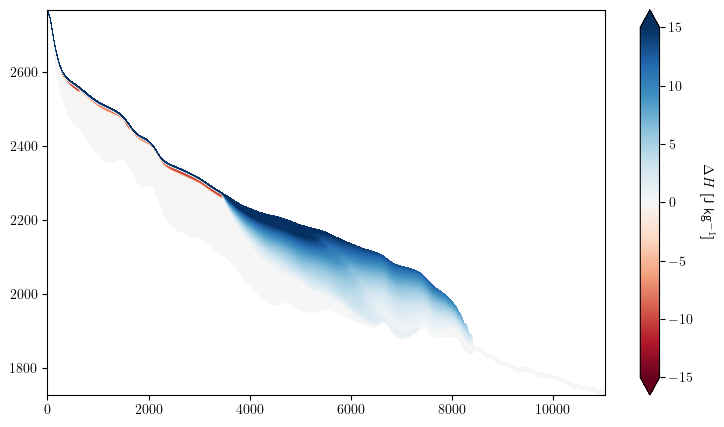

In [180]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

im = ax.contourf(src_list[0].X.squeeze()[:,::-1], 
               src_list[0].Z.isel(t=-1).squeeze(),
               (src_list[1].interp(coord_2 = np.arange(0,16), method="cubic").enthalpy_h.mean('t').squeeze() - src_list[0].enthalpy_h.mean('t').squeeze()) / 1e3, 
               # vmin=-30, vmax=30, 
               levels=np.linspace(-15,15, 200),
               extend='both',
               cmap='RdBu')

cbar = fig.colorbar(im, ticks=np.arange(-15,20,5))

cbar.set_label(r'$\Delta H$ [J kg$^{-1}$]', rotation=270, labelpad=15)